In [1]:
import pandas as pd
import random
import numpy as np
import seaborn as sns 
sns.set(style="darkgrid", font_scale=1.2) 
import matplotlib.pyplot as plt
from numpy.linalg import norm

data=pd.read_csv('E:\\Essay\\ratings_Books(1).csv')
data.columns =["userID", "itemID", "rating",'timestamp']
data.head(5)
data1 = data.copy()   #使用data1进行操作，避免误触data原数据又要再读取浪费时间
print(data.shape)
print(data.dtypes)
num_test=800000
data_final = data1.iloc[:num_test,0:]
data_final.shape


(22507154, 4)
userID        object
itemID        object
rating       float64
timestamp      int64
dtype: object


(800000, 4)

## 对不同N =100 / 50进行实验
### 在del_index = users_count[users_count<100].index    
### 100换50即可

In [2]:

users_count = data_final.userID.value_counts()
users_count


del_index = users_count[users_count<100].index                     #要删除的index=评分个数小于100的用户数据
data_final_1 = data_final[~data_final.userID.isin(del_index)]     
len(data_final_1)
data_final_1.shape

# Number of unique user id and product id in the sample dataset
print('样本数据data_final_1中的用户数 = ', data_final_1['userID'].nunique())
print('样本数据data_final_1中的产品数 = ', data_final_1['itemID'].nunique())

# 得到用户-商品评分矩阵
rating_matrix = data_final_1.pivot(index='userID',columns='itemID',values='rating')
rating_matrix.head()
final_ratings_matrix = rating_matrix.fillna(0)
final_ratings_matrix.head()
# 重新给userID编号,因为data_final_1不存在一个用户给同一本书两次评分，所以形成的用户-商品矩阵的用户不存在重复
final_ratings_matrix.reset_index(drop = True,inplace = True)
final_ratings_matrix.head()

样本数据data_final_1中的用户数 =  55
样本数据data_final_1中的产品数 =  6087


itemID,000077135X,000100039X,0001501232,0001839233,0001847775,0001848062,0001850032,0001850164,0002005395,0002007770,...,0062020161,006202017X,0062020188,0062020447,0062020455,006202048X,0062020560,0062020617,0062020625,0062020633
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 评分矩阵R

In [3]:
R = np.array(final_ratings_matrix)
R

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# 子函数部分

In [4]:
# Cosine
def Sim_cos(R):
    m,n = np.shape(R)
    S = np.zeros((m,m))
    for i in range(m):
        for j in range(m):
            S[i][j]=np.dot(R[i,:],R[j,:])/(norm(R[i,:])*norm(R[j,:]))
    return S

In [5]:
# 修正的余弦相似度
def Sim_acos(R):
    m,n = np.shape(R)
    S = np.zeros((m,m))
    a_item = R.sum(0)/(R != 0).sum(0) # 修正项:列-商品-均值（不计算0元素）
    R1 = R-a_item
    for i in range(m):
        for j in range(m):
            S[i][j]=np.dot(R1[i,:],R1[j,:])/(norm(R1[i,:])*norm(R1[j,:]))
    return S

In [6]:
# Pearson 相关系数
def Sim_pearson(R):
    m,n = np.shape(R)
    S = np.zeros((m,m))
    a_user = R.sum(1)/(R != 0).sum(1) # 修正项:行-用户-均值（不计算0元素）
    R2 = R-a_user[:, np.newaxis] # 将a_user转为列向量
    for i in range(m):
        for j in range(m):
            S[i][j]=np.dot(R2[i,:],R2[j,:])/(norm(R2[i,:])*norm(R2[j,:]))
    return S

In [7]:
# Jacard相关系数
def Sim_jacard(R):
    m,n = np.shape(R)
    S = np.zeros((m,m))
    for i in range(m):
        for j in range(m):
            num = len(set(R[i,:]).intersection(set(R[j,:])))
            denom = len(set(R[i,:]).union(set(R[j,:])))
            S[i][j]=num/denom
    return S

In [8]:
def Sim_spearman(R):
    R = pd.DataFrame(np.transpose(R))
    S=R.corr('spearman')
    return S

In [9]:
def Sim_kendall(R):
    R = pd.DataFrame(np.transpose(R))
    S=R.corr('kendall')
    return S

In [10]:
def Predication(R,S):
    m,n =np.shape(R)
    P = np.zeros((m,n))
    a_user = R.sum(1)/(R != 0).sum(1)
    for i in range(m):
        for j in range(n):
            if R[i][j]==0:
                num = np.dot((R[:,j]-a_user),S[i,:])
                denom = np.sum(abs(S[i,:]))
                P[i][j]=a_user[i]+num/denom
            elif R[i][j]!=0:
                P[i][j]=R[i][j]
    return P

In [11]:
def K_user(S,K):
#为每一个用户找到最相似的K个用户 + 创建空的user_candidate保存最终K个相似用户的ID结果
    user_candidate = {}
    S_pd = pd.DataFrame(S)
    #遍历每一行数据
    for i in S_pd.index:
        #取出每一列数据， 删除自己，按照相似度排序（降序）
        _df = S_pd.loc[i].drop([i])
        _df_sorted = _df.sort_values(ascending = False)
        #排序之后切片取出前两个值，传入空dict
        topK = list(_df_sorted.index[:K])
        user_candidate[i] = topK
    return user_candidate

In [12]:
def Rmse(user_candidate,R,P,K):
    R_pd = pd.DataFrame(R)
    P_pd = pd.DataFrame(P)
    Avg_actual_ratings_list=[]
    Avg_predicted_ratings_list=[]
    for i in user_candidate: 
        a = R_pd.loc[i]                             #a存放每个用户的实际评分值,是dataframe形式的一行
        Avg_actual_ratings = round(a[a!=0].mean(),2)   #遍历每个用户的实际评分值(评分为0不参与计算)，得到其均值
        Avg_predicted_ratings = P_pd.loc[user_candidate[i]].mean().mean()  #遍历每个用户的相似度最高的前K个用户的预测评分值，得到其均值
        Avg_actual_ratings_list.append(Avg_actual_ratings)   #Avg_actual_ratings_list 存放每个用户的实际评分均值
        Avg_predicted_ratings_list.append(Avg_predicted_ratings)#Avg_predicted_ratings_list存放每个用户的K个相似用户的预测评分均值
    rmse = (((np.array(Avg_predicted_ratings_list)-np.array(Avg_actual_ratings_list))**2).mean()/K)**0.5
    rmse = round(rmse,4)
    print('相似度 %d 邻居的RMSE值为: %f '%(K,rmse))
    return rmse

## 数据集计算--初始化

In [30]:
x = np.array([10,20,30,40,50])
#x = np.array([10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250])
rmse_cos = []
rmse_pea = []
rmse_acos = []
rmse_jaca = []

rmse_spearman = []
rmse_kendall = []

iterations = x.shape[0]

In [31]:
%%time
for i in range(iterations):
    K = x[i]
    #cos
    S = Sim_cos(R)
    P = Predication(R,S)
    user_candidate = K_user(S,K)
    rmse = Rmse(user_candidate,R,P,K)
    rmse_cos.append(rmse)

相似度 10 邻居的RMSE值为: 1.255300 
相似度 20 邻居的RMSE值为: 0.895800 
相似度 30 邻居的RMSE值为: 0.735700 
相似度 40 邻居的RMSE值为: 0.639200 
相似度 50 邻居的RMSE值为: 0.572600 
CPU times: total: 21 s
Wall time: 17.1 s


In [32]:
%%time
for i in range(iterations):
    K = x[i]
    #acos
    S = Sim_acos(R)
    P = Predication(R,S)
    user_candidate = K_user(S,K)
    rmse = Rmse(user_candidate,R,P,K)
    rmse_acos.append(rmse)

相似度 10 邻居的RMSE值为: 1.457100 
相似度 20 邻居的RMSE值为: 0.985400 
相似度 30 邻居的RMSE值为: 0.785000 
相似度 40 邻居的RMSE值为: 0.663300 
相似度 50 邻居的RMSE值为: 0.578300 
CPU times: total: 20.6 s
Wall time: 16.7 s


In [33]:
%%time
for i in range(iterations):
    K = x[i]
    #pearson
    S = Sim_pearson(R)
    P = Predication(R,S)
    user_candidate = K_user(S,K)
    rmse = Rmse(user_candidate,R,P,K)
    rmse_pea.append(rmse)

相似度 10 邻居的RMSE值为: 1.304500 
相似度 20 邻居的RMSE值为: 0.925700 
相似度 30 邻居的RMSE值为: 0.760400 
相似度 40 邻居的RMSE值为: 0.651000 
相似度 50 邻居的RMSE值为: 0.578400 
CPU times: total: 20.4 s
Wall time: 16.5 s


In [34]:
%%time
for i in range(iterations):
    K = x[i]
    #jacard
    S = Sim_jacard(R)
    P = Predication(R,S)
    user_candidate = K_user(S,K)
    rmse = Rmse(user_candidate,R,P,K)
    rmse_jaca.append(rmse)

相似度 10 邻居的RMSE值为: 1.241700 
相似度 20 邻居的RMSE值为: 0.906200 
相似度 30 邻居的RMSE值为: 0.740000 
相似度 40 邻居的RMSE值为: 0.643200 
相似度 50 邻居的RMSE值为: 0.570100 
CPU times: total: 42.8 s
Wall time: 42.8 s


In [35]:
%%time
for i in range(iterations):
    K = x[i]
    #spearman
    S = Sim_spearman(R)
    S1 = np.array(S)
    P = Predication(R,S1)
    user_candidate = K_user(S1,K)
    rmse = Rmse(user_candidate,R,P,K)
    rmse_spearman.append(rmse)

相似度 10 邻居的RMSE值为: 0.647100 
相似度 20 邻居的RMSE值为: 0.466700 
相似度 30 邻居的RMSE值为: 0.376200 
相似度 40 邻居的RMSE值为: 0.310100 
相似度 50 邻居的RMSE值为: 0.257100 
CPU times: total: 15.6 s
Wall time: 15.6 s


In [36]:
%%time
for i in range(iterations):
    K = x[i]
    #spearman
    S = Sim_kendall(R)
    S1 = np.array(S)
    P = Predication(R,S1)
    user_candidate = K_user(S1,K)
    rmse = Rmse(user_candidate,R,P,K)
    rmse_kendall.append(rmse)

相似度 10 邻居的RMSE值为: 0.651500 
相似度 20 邻居的RMSE值为: 0.468700 
相似度 30 邻居的RMSE值为: 0.377500 
相似度 40 邻居的RMSE值为: 0.311300 
相似度 50 邻居的RMSE值为: 0.258300 
CPU times: total: 19.2 s
Wall time: 19.3 s


In [37]:
print('rmse_cos的值为：',rmse_cos)
print('rmse_acos的值为：',rmse_acos)
print('rmse_pearson的值为：',rmse_pea)
print('rmse_jacard的值为：',rmse_jaca)
print('rmse_spearman的值为：',rmse_spearman)
print('rmse_kendall的值为：',rmse_kendall)

rmse_cos的值为： [1.2553, 0.8958, 0.7357, 0.6392, 0.5726]
rmse_acos的值为： [1.4571, 0.9854, 0.785, 0.6633, 0.5783]
rmse_pearson的值为： [1.3045, 0.9257, 0.7604, 0.651, 0.5784]
rmse_jacard的值为： [1.2417, 0.9062, 0.74, 0.6432, 0.5701]
rmse_spearman的值为： [0.6471, 0.4667, 0.3762, 0.3101, 0.2571]
rmse_kendall的值为： [0.6515, 0.4687, 0.3775, 0.3113, 0.2583]


# 剔除100以下
x = [10, 20, 30, 40, 50, 55]

y_cos = [1.2553, 0.8958, 0.7357, 0.6392, 0.5726]

y_pea = [1.3045, 0.9257, 0.7604, 0.6510, 0.5784]

y_acos = [1.4571, 0.9854, 0.7850, 0.6633, 0.5783]

y_jaca = [1.2417, 0.9062, 0.7400, 0.6432, 0.5701]

y_spearman = [0.6471, 0.4667, 0.3762, 0.3101, 0.2571]

y_kendall = [0.6515, 0.4687, 0.3775, 0.3113, 0.2583]

In [38]:
# 剔除100以下
x = [10,20,30,40,50]
y_cos = [1.2553, 0.8958, 0.7357, 0.6392, 0.5726]
y_pea = [1.3045, 0.9257, 0.7604, 0.6510, 0.5784]
y_acos =  [1.4571, 0.9854, 0.7850, 0.6633, 0.5783]
y_jaca = [1.2417, 0.9062, 0.7400, 0.6432, 0.5701]
y_spearman = [0.6471, 0.4667, 0.3762, 0.3101, 0.2571]
y_kendall = [0.6515, 0.4687, 0.3775, 0.3113, 0.2583]


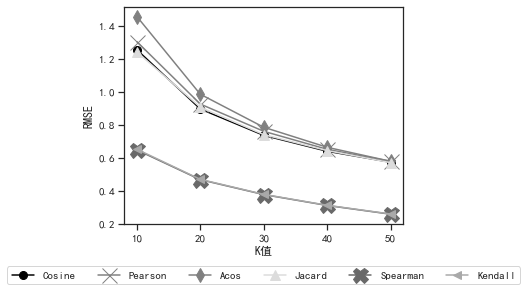

In [40]:
plt.figure(figsize=(5,4))

rc = {'font.sans-serif': 'SimHei',
      'axes.unicode_minus': False}
sns.set(context='notebook', style='ticks', rc=rc)
sns.set_style('ticks')


plt.rcParams['axes.unicode_minus'] = False # 用于显示中文 
#plt.title('基于不同相似度的评分预测结果比较')  # 折线图标题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示汉字
plt.xlabel('K值')  # x轴标题
plt.ylabel('RMSE')  # y轴标题

plt.plot(x,y_cos,marker='o',markersize=8,color='black',label='Cosine')
plt.plot(x,y_pea,marker='x',markersize=15,color='grey',label='Pearson')
plt.plot(x,y_acos,marker='d',markersize=10,color='gray',label='Acos')
plt.plot(x,y_jaca,marker='^',markersize=10,color='gainsboro',label='Jacard')
plt.plot(x,y_spearman,marker='X',markersize=15,color='dimgray',label='Spearman')
plt.plot(x,y_kendall,marker='<',markersize=8,color='darkgrey',label='Kendall')
plt.legend(bbox_to_anchor=(0.5,-0.3),loc=8,ncol=10)

plt.savefig('E:\Essay\CF_result_3.jpg',dpi=400,bbox_inches='tight') # 将N=100的结果记为CF_result_3保存